In [1]:
%matplotlib inline
%store -r

from time import time

from math import sqrt, floor
import numpy as np

import matplotlib.pyplot as plt
plt.style.use = "default"

import pandas as pd
pd.options.display.float_format = '{:.3f}'.format

from IPython.core.debugger import set_trace

import sys
sys.path.append('../../')
from rfc import RandomForest
from Experiment import Experiment

Unable to restore variable 'e', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Unable to restore variable 'e14', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>
Unable to restore variable 'e15', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>


In [2]:
train = pd.read_csv("cleaned_testData1.csv")
labels = pd.read_csv("cleaned_trainLabel1.csv")
test = pd.read_csv("TestData1.txt", sep='\t', header=None)

In [3]:
train = train.drop(train.columns[0], axis=1)
labels = labels.drop(labels.columns[0], axis=1) 

In [4]:
train.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160
count,149.000,149.000,149.000,149.000,149.000,149.000,149.000,149.000,149.000,149.000,...,149.000,149.000,149.000,149.000,149.000,149.000,149.000,149.000,149.000,149.000
mean,1.513,1.204,1.262,1.888,1.390,1.668,1.305,1.743,2.567,1.913,...,1.562,2.009,1.751,2.210,2.285,2.707,2.787,1.225,1.920,2.801
std,0.410,0.404,0.437,0.342,0.460,0.560,0.370,0.333,0.119,0.209,...,0.446,0.163,0.298,0.124,0.199,0.142,0.171,0.369,0.294,0.134
min,1.000,1.000,1.000,1.257,1.000,1.000,1.000,1.000,2.349,1.343,...,1.000,1.651,1.000,1.894,1.829,2.389,2.391,1.000,1.483,2.493
25%,1.231,1.000,1.000,1.676,1.000,1.315,1.000,1.586,2.493,1.793,...,1.031,1.897,1.583,2.114,2.154,2.599,2.678,1.000,1.758,2.727
50%,1.475,1.000,1.000,1.839,1.252,1.652,1.198,1.727,2.549,1.896,...,1.597,2.005,1.723,2.197,2.262,2.707,2.785,1.000,1.863,2.780
75%,1.659,1.204,1.361,2.026,1.570,1.842,1.455,1.853,2.609,1.996,...,1.872,2.103,1.866,2.283,2.386,2.798,2.897,1.327,1.955,2.847
max,3.027,2.713,2.862,2.984,2.754,3.507,2.306,2.760,2.986,2.573,...,2.658,2.861,2.856,2.579,2.945,3.285,3.274,2.728,3.050,3.263


In [5]:
def merge(df, labels):
    return labels.merge(df, left_index=True,right_index=True)

In [6]:
def mprint(*args):
    for arg in args:
        print(arg)
        print(" ")

In [7]:
merge(train, labels).groupby("label").describe()

f0                                                f1        ...   \
        count  mean   std   min   25%   50%   75%   max   count  mean  ...    
label                                                                  ...    
1     107.000 1.444 0.285 1.000 1.247 1.465 1.614 2.378 107.000 1.099  ...    
2      14.000 1.190 0.235 1.000 1.000 1.051 1.370 1.630  14.000 1.000  ...    
3      11.000 1.320 0.245 1.000 1.175 1.294 1.438 1.837  11.000 1.019  ...    
4      14.000 2.352 0.248 2.081 2.167 2.300 2.451 3.027  14.000 2.277  ...    
5       3.000 2.250 0.327 1.883 2.120 2.357 2.434 2.512   3.000 1.590  ...    

        f98           f99                                            
        75%   max   count  mean   std   min   25%   50%   75%   max  
label                                                                
1     2.425 2.565 107.000 2.622 0.102 2.388 2.549 2.625 2.693 2.883  
2     2.487 2.521  14.000 2.586 0.087 2.431 2.530 2.581 2.615 2.796  
3     2.458 2.541  11.000 2.785 0.057 2.661 2.762 2.788 2.804 2.871  
4     2.657 2.799  14.000 2.869 0.146 2.655 2.766 2.864 2.936 3.125  
5     2.542 2.576   3.000 2.713 0.091 2.629 2.664 2.699 2.755 2.810  

[5 rows x 1288 columns]

---  

# Model Building

## Which algorithm to use?
We'll use a **random forest classifier** (rfc) with bootstrapping and feature bagging optimizations because:
- ease of implementation
- rfcs handle multi-class predictions well without more additional effort
- works well with high dimensional data
- we'll choose use random forest as opposed to boosted trees since we have highly dimensional data
- with a reasonably high probability, can be used with the other datasets for this project since the algorithm is very robust

## The Algorithm
We'll use the CART algorithm for splitting since we have continuous data.  
  
[Full example](https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/)  
  
Steps:
1. Initialize Tree
2. For each column, calc best split across all rows based using gini impurity score - [exmplanation](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) | [exmaple](https://www.researchgate.net/post/How_to_compute_impurity_using_Gini_Index) | [useful blog](http://dni-institute.in/blogs/cart-algorithm-for-decision-tree/)
3. Split the dataset based on the split condition with the highest gini score and add both sets as leaves on a tree node. The node represents a decision point, that being the condition with the highest gini score.
3. Repeat 2 & 3 until an arbitrary minimum number of rows are left
4. Prune tree

ideas:
- instead of using the raw values, categorize the numbers as # of stds away from mean
- > Alternatively, the random forest can apply weight concept for considering the impact of result from any decision tree. Tree with high error rate are given low weight value and vise versa. This would increase the decision impact of trees with low error rate - [medium post](https://medium.com/machine-learning-101/chapter-5-random-forest-classifier-56dc7425c3e1)
- [parameters to  tune](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/
- https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
- https://stats.stackexchange.com/questions/260460/optimization-of-a-random-forest-model
- https://followthedata.wordpress.com/2012/06/02/practical-advice-for-machine-learning-bias-variance/
- https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

---  
# Model Training & Tuning
## Context
Now that we have our classifier, let's think about how we're going to train the model. 

We'll also measure performance through [precision](https://en.wikipedia.org/wiki/Precision_and_recall) & [recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c) - it tells us, for each class, how well the model identifies all cases of that class (recall) and how well it can correctly classify those cases (precision). From wikipedia:
> Suppose a computer program for recognizing dogs in photographs identifies eight dogs in a picture containing 12 dogs and some cats. Of the eight dogs identified, five actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12.

![precision & recall formulas](https://cdn-images-1.medium.com/max/2000/1*6NkN_LINs2erxgVJ9rkpUA.png)
We can use the [f1 score](https://en.wikipedia.org/wiki/F1_score) to maximize precision and recall when testing different models.  
![f1 score formula](https://cdn-images-1.medium.com/max/1600/1*UJxVqLnbSj42eRhasKeLOA.png)

Recall and precision seem to be very related to bias and variance of the model, so we can maximize the f1 score by tuning the model to affect these.
#### Minimizing bias
- use new/different features
- increase the size of the trees (increases variance)
- increase the number of trees in the forest

#### Minimizing variance
- decrease the number of features
    + probably want to aim to features that are correlated and/or collapse the overall number of features through PCA
- use more data for each tree  

  
Beware: too much completixy is bad & not enough complexity is also bad  
![bias variance tradeoff](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)  
  

#### Stability
We need to make sure to train the classifier on as many data points as possible while also leaving enough to test to reliably tell how well the classifier actually performs. We'll use [k-fold cross validation](https://www.analyticsvidhya.com/blog/2015/11/improve-model-performance-cross-validation-in-python-r/):  
  
> 1. Randomly split your entire dataset into k ”folds”.
2. For each k folds in your dataset, build your model on k – 1 folds of the data set. Then, test the model to check the effectiveness for kth fold.
3. Record the error you see on each of the predictions.
4. Repeat this until each of the k folds has served as the test set.

## Procedure
1. Record and save an input configuration for the random forest
1. Separate data into k folds
2. For each fold *k*: 
    1. train the classifier on k-1 folds
    2. predict the k-th fold
    3. measure the: accuracy, [logarithmic](http://wiki.fast.ai/index.php/Log_Loss) [loss](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234#f217), recall, precision, and f1-score
3. Record the performance measures & associate it with the input configuration
3. Evaluate the overall performance difference across all configurations
4. Change variables from the input configuration that optimizes model perfomance & repeat steps 1-5

![WOWZA](https://i.imgur.com/hzxSFl5.png)

In [8]:
init_config_names = ["num_trees", "num_features", "num_sample_rows", "max_tree_depth", "min_split_samples", "bias_class", "bias_amount"]
init_config_values = [   10,          None,           None,              20,                5,                 None,            0] # default settings = initial settings

e = Experiment(train, labels, RandomForest, init_config_names, init_config_values)

In [9]:
t1 = e.run_trial()
%store e

Running trail #1
------------------------------------
 
*************************
 
Running fold 1 of 10
 
*************************
 
fold 1 took 53.488991022109985s
 
*************************
 
Running fold 2 of 10
 
*************************
 


/usr/local/Cellar/python3/3.5.0/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fold 2 took 51.035489082336426s
 
*************************
 
Running fold 3 of 10
 
*************************
 
fold 3 took 55.5192608833313s
 
*************************
 
Running fold 4 of 10
 
*************************
 
fold 4 took 88.43484807014465s
 
*************************
 
Running fold 5 of 10
 
*************************
 
fold 5 took 78.9311318397522s
 
*************************
 
Running fold 6 of 10
 
*************************
 
fold 6 took 77.27893304824829s
 
*************************
 
Running fold 7 of 10
 
*************************
 
fold 7 took 67.64726614952087s
 
*************************
 
Running fold 8 of 10
 
*************************
 
fold 8 took 67.07492399215698s
 
*************************
 
Running fold 9 of 10
 
*************************
 
fold 9 took 58.04343509674072s
 
*************************
 
Running fold 10 of 10
 
*************************
 
fold 10 took 68.30269289016724s
 
Stored 'e' (Experiment)


In [10]:
perf, train_test = e.trial_results()

## Trial 1 Notes:

These settings were default. Since we have 5 classes, the range of log loss is between 0 and 1.6, meaning our log loss is pretty bad and that we're very likely to misclassify. The accuracy seems good, but that's only because class 1 has a higher chance to appear in general as it appears ~70% of the time. As we see in iteration 7, accuracy and precision are _.533_ and _.284_  respectively. That iteration probably had more diverse labels than usual, but the model only got it right $\frac{1}{4}^{th}%$ of the time. 

In [12]:
model, t_7_train, t_7_test, t_7_predict  = e.experiment_data[6]

t_7_train_g = merge(t_7_train[0], labels).groupby("label")
t_7_test_g = merge(t_7_test, labels).groupby("label")

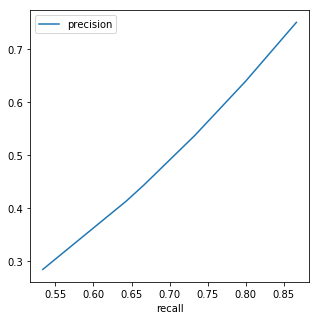

In [13]:
e.experiments.sort_values(["recall", "precision"]).plot("recall", "precision", "line", figsize=(5,5))

Very odd that precision and recall move in step.. Not sure what that means.

In [14]:
e.experiments[e.performance_measures()].mean()

log_loss         1.609
class_accuracy   0.711
precision        0.518
recall           0.711
f1-score         0.596
support            nan
dtype: float64

In [16]:
expected_means = merge(train, labels).groupby("label").count().apply(lambda x: x / train.shape[0]).T.mean()

# average bias
# pd.DataFrame([i[2].value_counts(normalize=True) - expected_means for i in e.experiment_data]).mean()

Overall, it seems like the classifier is stuck on the imbalance of classes in the dataset. We have close to 0 variance but lots of bias. We can count the `nan`s above as $0 - class$.  

To combat this, we'll add more & deeper trees in hopes that the model will pick up on more variance, train some trees only on data that have the imbalanced classes, and use less data to train the model with in order to reduce the extent to which a single class and dominate the others.  
  
We can also increase the number of samples that we give a tree to something that will mirror the overall statistical properties of the original set.

In [17]:
# run this a few times to minimize s_rows and statistical difference in label means
s_rows = 60
row_indices = np.random.choice(train.shape[0], size=s_rows, replace=False)
merge(train.iloc[row_indices], labels).groupby("label").count().apply(lambda x: x / s_rows).T.mean()

label
1   0.783
2   0.050
3   0.050
4   0.117
dtype: float64

In [18]:
e.tweak("num_trees", 20).tweak("min_split_samples", 1).tweak("num_sample_rows", s_rows).tweak("num_features", 20).tweak("bias_class", 1).tweak("bias_amount", .7)

In [19]:
if e.experiments[e.experiments["trial_num"] > 1].shape[0] < 2:
    e.run_trial()
    %store e

Running trail #11
------------------------------------
 
*************************
 
Running fold 1 of 10
 
*************************
 


Process ForkPoolWorker-611:
Process ForkPoolWorker-610:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.5.0/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python3/3.5.0/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python3/3.5.0/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

In [ ]:
t2_results, t2_train_test =  e.trial_results()

In [ ]:
t2_results

In [ ]:
# e.experiments
e.experiment_data[9][2].to_csv("predictions.txt", sep="\t", index=False)

In [ ]:
t2_results.sort_values(["recall", "precision"]).plot("recall", "precision", "line", figsize=(5,5))

## Trial 2 Notes:
Welp - that didn't work.

In [ ]:
t2_results

In [24]:
r = e.experiment_data[0][0].predict(test)
r.to_csv("predictions1.txt", sep="\t", index=False, header=False)

Exception: `row` must be an instance of Pandas.Series

** ORIGIN RUNTIME **  
$ O(folds * trees * max_depth * row^{columns})  $

** PARALLELIZED RUNTIME **
$ O(folds * trees * max_depth * row^{\frac{columns}{threads}})  $